In [29]:
# Import necessary libraries
from src.models import RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn
import scipy.signal as signal

# Set data type and device
dtype = torch.float
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")

# Close all open plots
plt.close('all')

In [30]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output.mat')
data_out = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__ = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__']
    
nExp = yExp.size


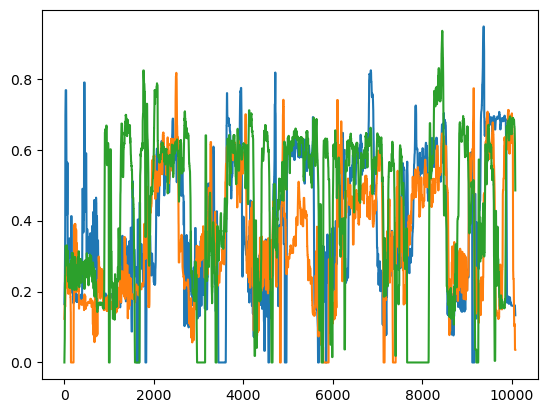

In [31]:
# Create time vector
#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts, Ts)
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
input_size = 5
u = torch.zeros(nExp, t_end, input_size)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = input_size-1

# Fill input and output tensors with data
for j in range(nExp):
    #inputActive = (torch.from_numpy(dExp[0, j]))
    #if input_size ==4:
     #   u[j, :, :] = (torch.from_numpy(dExp[0, j][:, :-1])) #suppress last column
    #else :
    u[j, :, :] = (torch.from_numpy(dExp[0, j]))        
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    
    u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 25))
    plt.plot(u[j, :, 4])

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [34]:
#Set dimensions for RNN layers
idd = input_size
hdd = 15
ldd = 1
odd = yExp[0, 0].shape[1]

# Initialize RNN model
RNN = RNNModel(idd, hdd, ldd, odd)

# Define loss function
MSE = nn.MSELoss()

# Define optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 500

# Initialize array to store loss values
LOSS = np.zeros(epochs)


In [35]:
# Train the RNN model
for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    # Get RNN output for training data
    yRNN = RNN(u)
    yRNN = torch.squeeze(yRNN)
    

    # Calculate loss and backpropagate
    loss = MSE(yRNN, y)
    loss.backward()
    optimizer.step()
    

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss

Epoch: 1 	||	 Loss: 0.695805549621582
Epoch: 2 	||	 Loss: 0.6178752183914185
Epoch: 3 	||	 Loss: 0.5452145934104919
Epoch: 4 	||	 Loss: 0.4762413203716278
Epoch: 5 	||	 Loss: 0.4103297293186188
Epoch: 6 	||	 Loss: 0.34577617049217224
Epoch: 7 	||	 Loss: 0.28037476539611816
Epoch: 8 	||	 Loss: 0.2134387493133545
Epoch: 9 	||	 Loss: 0.14635077118873596
Epoch: 10 	||	 Loss: 0.08481328189373016
Epoch: 11 	||	 Loss: 0.04144330322742462
Epoch: 12 	||	 Loss: 0.03699681535363197
Epoch: 13 	||	 Loss: 0.06914575397968292
Epoch: 14 	||	 Loss: 0.0890907421708107
Epoch: 15 	||	 Loss: 0.07861391454935074
Epoch: 16 	||	 Loss: 0.05323315039277077
Epoch: 17 	||	 Loss: 0.02981731668114662
Epoch: 18 	||	 Loss: 0.01588616333901882
Epoch: 19 	||	 Loss: 0.011422782205045223
Epoch: 20 	||	 Loss: 0.01326174195855856
Epoch: 21 	||	 Loss: 0.018011262640357018
Epoch: 22 	||	 Loss: 0.02317056804895401
Epoch: 23 	||	 Loss: 0.0272515881806612
Epoch: 24 	||	 Loss: 0.02956131286919117
Epoch: 25 	||	 Loss: 0.029947651

In [36]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, input_size)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))#[:,:-1]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 25))

# Get RNN output for validation data
yRNN_val = RNN(uval)
yRNN_val = yRNN_val.unsqueeze_(0)

# Calculate loss for validation data
loss_val = MSE(yRNN_val, yval)

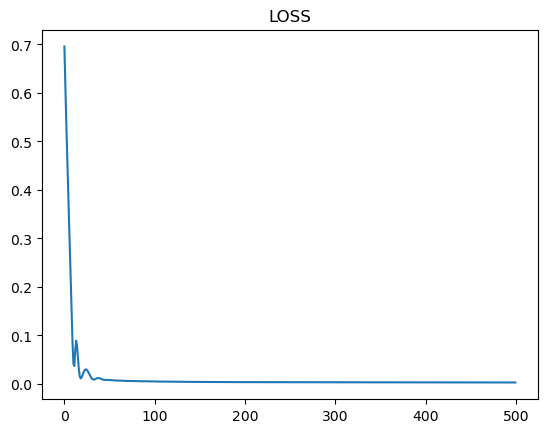

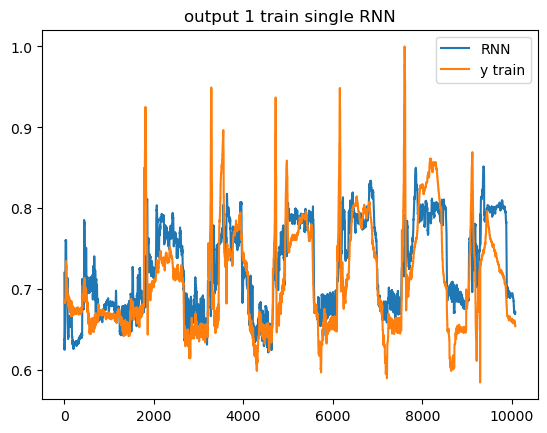

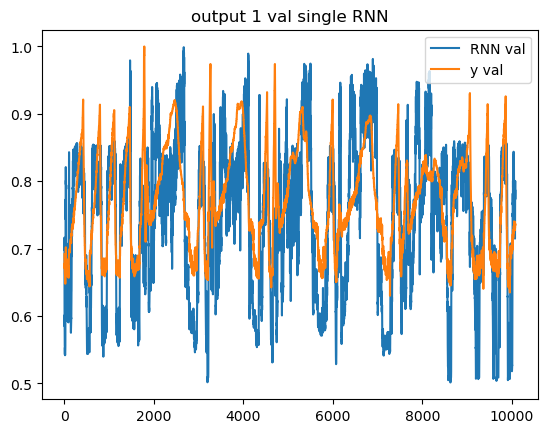

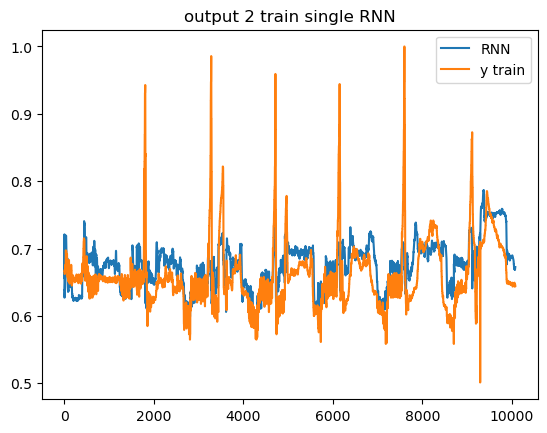

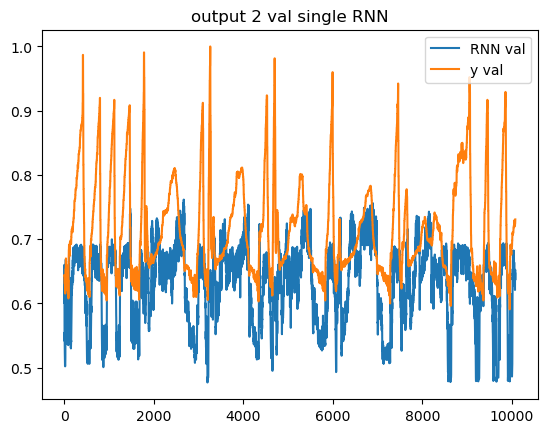

Loss Validation single RNN: 0.00937492772936821


In [37]:
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS")
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(yRNN[0, :, 0].detach().numpy(), label='RNN')
plt.plot(y[0, :, 0].detach().numpy(), label='y train')
plt.title("output 1 train single RNN")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yRNN_val[0, :, 0].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 0].detach().numpy(), label='y val')
plt.title("output 1 val single RNN")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(yRNN[0, :, 1].detach().numpy(), label='RNN')
plt.plot(y[0, :, 1].detach().numpy(), label='y train')
plt.title("output 2 train single RNN")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yRNN_val[0, :, 1].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 1].detach().numpy(), label='y val')
plt.title("output 2 val single RNN")
plt.legend()
plt.show()

# Save RNN output and validation data to file
scipy.io.savemat('data_singleRNN_sysID.mat', dict(yRENm_val=yRNN_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single RNN: {loss_val}")